In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans

In [56]:
one_hot = pd.read_csv("one_hot_responses.csv")
one_hot = one_hot.drop(columns=["Unnamed: 0"])

In [116]:
# Very masculine, Somewhat masculine, Not very masculine, Not at all masculine
#masculinity_scale = [col for col in one_hot.columns if col.startswith('q0001')]
# Straight, Gay, Bisexual, Other
#sexuality_scale = [col for col in one_hot.columns if col.startswith('q0026')]
# print(masculinity_scale)
#print(sexuality_scale)

# top n pca
n = 50
predictors = [one_hot.columns[i] for i in range(len(one_hot.columns))]
X = one_hot[predictors].values.T

#don't need to standardize since they're dummy variables? idk I asked on piazza
#but when standardizing, if we try to have more than 30 PCs it causes a LinAlgError: Singular matrix error

#n_i, n_j = X.shape
#stds = np.std(X, axis=1)
#stds = np.repeat(np.reshape(stds, (-1,1)), n_j, axis=1)
#S = X/stds
pca = PCA(n_components=n)
pcs = pca.fit_transform(X.T)
df_pcs = pd.DataFrame(pcs, columns=['PC'+str(i+1) for i in range(n)])

# predict whether the person was gay based on their survey responses
df_pcs['y'] = one_hot['q0001'].values

In [ ]:
# 10 fold cross validation, linear regression
mean_mses = []
kf = KFold(n_splits=10, shuffle=True)
pc_numbers = [i+1 for i in range(n)]
# linear models using top k=1,2,3,...,20
for num_pc in pc_numbers:
    # do 10-fold cross validation
    train_mses = []
    test_mses = []
    for train_idx, test_idx in kf.split(df_pcs):
        df_train = df_pcs.iloc[train_idx, :]
        df_test = df_pcs.iloc[test_idx, :]
        
        # generate formula
        formula = 'y ~ 1'
        for num in range(1, num_pc+1):
            formula += (' + PC%d' % num)
            
        # fit model with df_train
        res = smf.ols(formula=formula, data=df_train).fit()

        # MSE of training set
        train_pred = res.predict(df_train)
        mse_train = np.mean((train_pred - df_train.y)**2)

        # MSE of test set
        test_pred = res.predict(df_test)
        mse_test = np.mean((test_pred - df_test.y)**2)

        # store results
        train_mses.append(mse_train)
        test_mses.append(mse_test)



    # report average training MSE and testing MSE
    mean_train_mse = np.mean(train_mses)
    mean_test_mse = np.mean(test_mses)
    
    mean_mses.append({'num_pc': num_pc,
                      'formula': formula,
                    'mean_train_mse': mean_train_mse,
                     'mean_test_mse': mean_test_mse})
    
    
df_res = pd.DataFrame(mean_mses)
df_res

In [ ]:
fig, ax = plt.subplots()
ax.plot(df_res.num_pc, df_res.mean_train_mse, label='training set')
ax.plot(df_res.num_pc, df_res.mean_test_mse, label='test set')
ax.legend()
ax.set_xlabel('number of top PC used')
ax.set_ylabel('Mean squared error')
plt.show()
best_model = df_res.loc[df_res.mean_test_mse.argmin()]
best_model

In [63]:
def accuracy(predictions, true):
    correct = (predictions == true)
    acc = sum(correct) / len(correct)
    return acc

In [97]:
# 10 fold cross validation, logistic regression
df_pcs = df_pcs.fillna(0)
mean_mses = []
kf = KFold(n_splits=10, shuffle=True)
pc_numbers = [i+1 for i in range(n)]
# linear models using top k=1,2,3,...,20
for num_pc in pc_numbers:
    # do 10-fold cross validation
    train_mses = []
    train_accs = []
    test_mses = []
    test_accs = []
    for train_idx, test_idx in kf.split(df_pcs):
        df_train = df_pcs.iloc[train_idx, :]
        df_test = df_pcs.iloc[test_idx, :]
        
        # generate formula
        formula = 'y ~ 1'
        for num in range(1, num_pc+1):
            formula += (' + PC%d' % num)
            
        # fit model with df_train
        res = smf.logit(formula=formula, data=df_train).fit(disp=0)

        # MSE of training set
        train_pred = 1*(res.predict(df_train) > 0.5)
        mse_train = np.mean((train_pred - df_train.y)**2)
        acc_train = accuracy(train_pred, df_train.y)

        # MSE of test set
        test_pred = 1*(res.predict(df_test) > 0.5)
        mse_test = np.mean((test_pred - df_test.y)**2)
        acc_test = accuracy(test_pred, df_test.y)

        # store results
        train_mses.append(mse_train)
        test_mses.append(mse_test)
        train_accs.append(acc_train)
        test_accs.append(acc_test)

    # report average training MSE and testing MSE
    mean_train_mse = np.mean(train_mses)
    mean_test_mse = np.mean(test_mses)
    mean_train_acc = np.mean(train_accs)
    mean_test_acc = np.mean(test_accs)
    
    mean_mses.append({'num_pc': num_pc,
                      'formula': formula,
                    'mean_train_mse': mean_train_mse,
                     'mean_test_mse': mean_test_mse,
                     'mean_train_acc': mean_train_acc,
                     'mean_test_acc': mean_test_acc})
    
    
df_res = pd.DataFrame(mean_mses)
df_res

,formula,mean_test_acc,mean_test_mse,mean_train_acc,mean_train_mse,num_pc
0,y ~ 1 + PC1,0.971559,0.028441,0.971518,0.028482,1
1,y ~ 1 + PC1 + PC2,0.971524,0.028476,0.971517,0.028483,2
2,y ~ 1 + PC1 + PC2 + PC3,0.971528,0.028472,0.971517,0.028483,3
3,y ~ 1 + PC1 + PC2 + PC3 + PC4,0.971544,0.028456,0.971517,0.028483,4
4,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5,0.971498,0.028502,0.971517,0.028483,5
5,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6,0.971521,0.028479,0.971517,0.028483,6
6,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7,0.971505,0.028495,0.971517,0.028483,7
7,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...,0.971494,0.028506,0.971517,0.028483,8
8,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...,0.971513,0.028487,0.971586,0.028414,9
9,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...,0.971517,0.028483,0.972755,0.027245,10


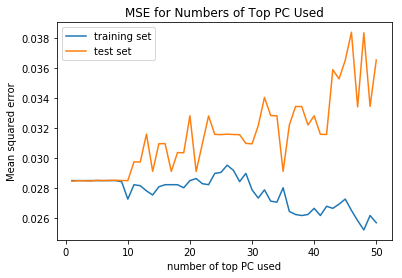

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  # Remove the CWD from sys.path while we load stuff.


formula           y ~ 1 + PC1
mean_test_acc        0.971559
mean_test_mse       0.0284411
mean_train_acc       0.971518
mean_train_mse      0.0284825
num_pc                      1
Name: 0, dtype: object

In [99]:
fig, ax = plt.subplots()
ax.plot(df_res.num_pc, df_res.mean_train_mse, label='training set')
ax.plot(df_res.num_pc, df_res.mean_test_mse, label='test set')
ax.legend()
#ax.set_xticks(df_res.num_pc.values)
ax.set_xlabel('number of top PC used')
ax.set_ylabel('Mean squared error')
plt.title("MSE for Numbers of Top PC Used")
plt.show()
best_model = df_res.loc[df_res.mean_test_mse.argmin()]
best_model

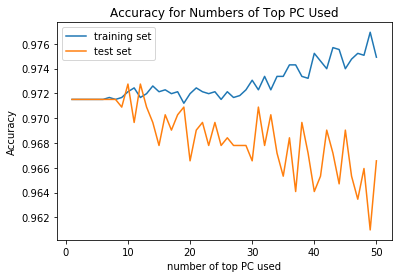

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  # Remove the CWD from sys.path while we load stuff.


formula           y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...
mean_test_acc                                              0.972755
mean_test_mse                                             0.0272446
mean_train_acc                                             0.972136
mean_train_mse                                            0.0278638
num_pc                                                           10
Name: 9, dtype: object

In [95]:
fig, ax = plt.subplots()
ax.plot(df_res.num_pc, df_res.mean_train_acc, label='training set')
ax.plot(df_res.num_pc, df_res.mean_test_acc, label='test set')
ax.legend()
#ax.set_xticks(df_res.num_pc.values)
ax.set_xlabel('number of top PC used')
ax.set_ylabel('Accuracy')
plt.title("Accuracy for Numbers of Top PC Used")
plt.show()
best_model = df_res.loc[df_res.mean_test_acc.argmax()]
best_model

In [100]:
print(pca.explained_variance_ratio_) 

[0.13063776 0.05241703 0.0446671  0.02854428 0.02477324 0.02168845
 0.01967303 0.0187394  0.0175984  0.01754494 0.01530753 0.01482908
 0.01430409 0.01343949 0.01316659 0.01262988 0.01200259 0.01189414
 0.01155252 0.01141856 0.01114524 0.0110375  0.01072254 0.01055183
 0.0103372  0.00988384 0.00983108 0.00963673 0.00932305 0.00903329
 0.00877642 0.00868934 0.00850439 0.00846098 0.00832256 0.00815683
 0.00808265 0.00783895 0.00775342 0.0075804  0.00738457 0.00730809
 0.00709899 0.00696577 0.00690193 0.00666241 0.00641991 0.00635147
 0.00615117 0.00592007]


In [118]:
feature_importance = pd.DataFrame(pca.components_,columns=one_hot.columns,index = ['PC'+str(i+1) for i in range(n)])

In [120]:
feature_importance.idxmax(axis=1)

PC1                            q0009_Not employed-retired
PC2                                q0025_0003_No children
PC3                                q0025_0003_No children
PC4                               q0025_0003_Not selected
PC5                               q0004_0002_Not selected
PC6                               q0011_0004_Not selected
PC7     q0020_0001_Read their physical body language t...
PC8                               q0020_0005_Not selected
PC9                                             q0005_Yes
PC10                              q0020_0004_Not selected
PC11                                             q0005_No
PC12              q0020_0004_Every situation is different
PC13                                    q0007_0004_Rarely
PC14                              q0020_0004_Not selected
PC15                                             q0017_No
PC16                              q0020_0004_Not selected
PC17                    q0004_0006_Other (please specify)
PC18          